<a href="https://colab.research.google.com/github/onebottlekick/bhban_ai_pytorch/blob/main/CNN/style_transfer/StyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import urllib

import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from IPython import display
from PIL import Image

In [2]:
os.makedirs('samples', exist_ok=True)

def download(img, root='https://github.com/onebottlekick/bhban_ai_pytorch/raw/main/CNN/style_transfer/samples/'):
    file_path = os.path.join('samples', img)
    urllib.request.urlretrieve(root+img, file_path)

content = 'content.jpg'
content_path = os.path.join('samples', content)

style = 'style.jpg'
style_path = os.path.join('samples', style)

download(content)
download(style)

In [3]:
def load_img(img, transform, device):
    img = Image.open(img).convert('RGB')
    img = transform(img)
    
    return img.to(device)


def gram_matrix(x):
    N, C, H, W = x.shape
    features = x.view(N*C, H*W)
    gram = torch.mm(features, features.t())
    return gram/(2*N*C*H*W)


def plot(img, title=None):
    plt.axis('off')
    if title:
        plt.title(title)
    plt.imshow(img)
    plt.show()

In [4]:
class StyleTransfer:
    def __init__(self, device, layers={1:'s', 2:'s', 3:'s', 4:'sc', 5:'s'}):
        self.layers = layers        
        self.model = self._get_model().to(device)
    
    def _get_model(self):
        vgg = nn.ModuleList(models.vgg19(pretrained=True).features)
        
        for param in vgg.parameters():
            param.requires_grad_(False)
        
        conv_idx = []   
        for idx, layer in enumerate(vgg):
            if isinstance(layer, nn.MaxPool2d):
                layer = nn.AvgPool2d(kernel_size=layer.kernel_size, stride=layer.stride, padding=layer.padding)
            
            elif isinstance(layer, nn.Conv2d):
                conv_idx.append(idx)
        
        model = nn.Sequential(*vgg[:conv_idx[len(self.layers)]])
        self.conv_idx = conv_idx
        
        return model

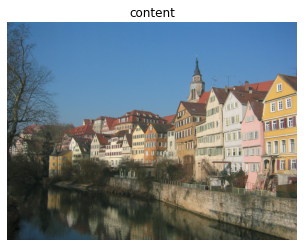

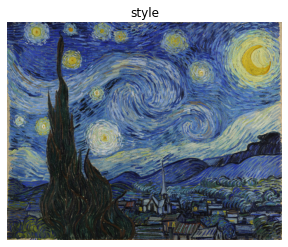


Epoch [01/301] content_loss=34.537689, style_loss=0.003915
total_loss=73.684418


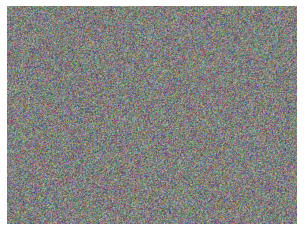



Epoch [51/301] content_loss=0.738784, style_loss=0.000057
total_loss=1.313586


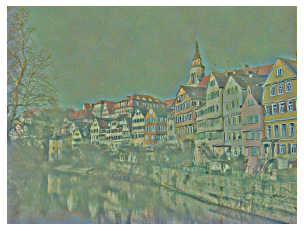



Epoch [101/301] content_loss=0.259877, style_loss=0.000050
total_loss=0.760976


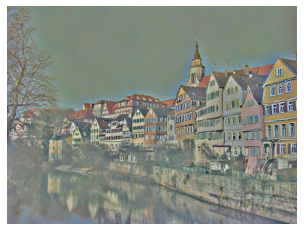



Epoch [151/301] content_loss=0.199778, style_loss=0.000049
total_loss=0.686944


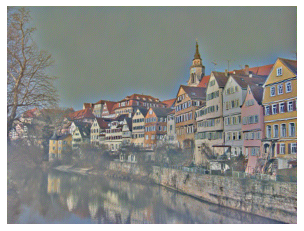



Epoch [201/301] content_loss=0.175837, style_loss=0.000048
total_loss=0.657548


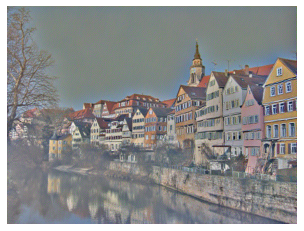



Epoch [251/301] content_loss=0.162914, style_loss=0.000048
total_loss=0.641813


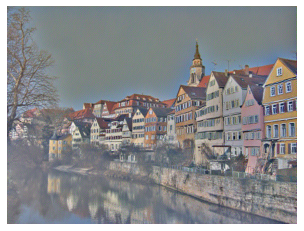



Epoch [301/301] content_loss=0.155170, style_loss=0.000048
total_loss=0.631892


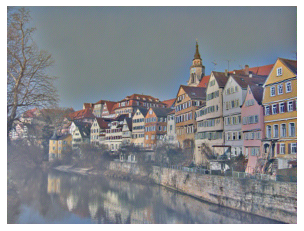

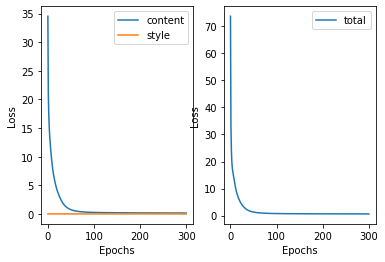

In [5]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

style_transfer = StyleTransfer(DEVICE)
model = style_transfer.model
layers = style_transfer.layers
conv_idx = style_transfer.conv_idx

resize = 500
transform = transforms.Compose([
    transforms.Resize(resize),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

content = load_img(content_path, transform, DEVICE).unsqueeze(0)
style = load_img(style_path, transform, DEVICE).unsqueeze(0)

plot(content.squeeze().permute(1, 2, 0).cpu().numpy(), title='content')
print()
plot(style.squeeze().permute(1, 2, 0).cpu().numpy(), title='style')

noise = torch.rand(content.shape, device=DEVICE, requires_grad=True)

NUM_EPOCHS = 301
learning_rate = 0.1
alpha = 1e+0
beta = 1e+4

optimizer = torch.optim.Adam([noise], lr=learning_rate)
criterion = nn.MSELoss()

content_losses = []
style_losses = []
total_losses = []
for epoch in range(NUM_EPOCHS):
    optimizer.zero_grad()
    style_loss = 0
    content_loss = 0
    
    noise.data.clip_(0, 1)
    for idx in layers.keys():
        if 'c' in layers[idx]:
            target_content = model[:conv_idx[idx]+1](content).detach()
            noise_content = model[:conv_idx[idx]+1](noise)
            content_loss += criterion(noise_content, target_content)
        if 's' in layers[idx]:
            target_style = gram_matrix(model[:conv_idx[idx]+1](style)).detach()
            noise_style = gram_matrix(model[:conv_idx[idx]+1](noise))
            style_loss += criterion(noise_style, target_style)
            
    content_losses.append(content_loss.item())
    style_losses.append(style_loss.item())
    
    total_loss = alpha*content_loss + beta*style_loss
    total_losses.append(total_loss.item())
    total_loss.backward()
    optimizer.step()
    
    if epoch % 50 == 0:
        print('='*70)
        print()
        print(f'Epoch [{epoch+1:02}/{NUM_EPOCHS}] content_loss={content_loss:6f}, style_loss={style_loss:.6f}')
        print(f'total_loss={total_loss:.6f}')
        plot(noise.data.clip_(0, 1).squeeze(0).cpu().detach().numpy().transpose(1, 2, 0))
        print()
        print('='*70)


plt.title('Loss')
plt.subplot(1, 2, 1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(content_losses, label='content')
plt.plot(style_losses, label='style')
plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(total_losses, label='total')
plt.legend()

plt.show()